In [51]:
import pandas as pd
import numpy as np
import os
import ast
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
os.getcwd()

'/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/study/taxi_trajectory'

In [4]:
df_train = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/train.csv")
df_test = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/test.csv")
df_loc = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/metaData_taxistandsID_name_GPSlocation.csv")

In [5]:
df_train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [6]:
df_loc.head()

,ID,Descricao,Latitude,Longitude
0,1,Agra,41.1771457135,-8.609670
1,2,Alameda,41.15618964,-8.591064
2,3,Aldoar,41.1705249231,-8.665876
3,4,Alfândega,41.1437639911,-8.621803
4,5,Amial,41.1835097223,-8.612726


In [7]:
print("train: ",df_train.shape)
print("test: ",df_test.shape)
print("location: ",df_loc.shape)

train:  (1710670, 9)
test:  (320, 9)
location:  (63, 4)


## EDA

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [9]:
df_train.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

ORIGIN_CALL, ORIGIN_STAND columns are many missing values, then handle later.

## feature engineering

In [10]:
df_sample = df_train.sample(frac=0.03, random_state=42).reset_index(drop=True)
df_sample.shape

(51320, 9)

In [11]:
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[..."
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8..."
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-..."
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[..."
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[..."


In [12]:
# gerenete features from POLYLINE
df_sample["polyline_list"] = df_sample["POLYLINE"].apply(lambda x: ast.literal_eval(x))
df_sample["n_points"] = df_sample["polyline_list"].apply(lambda x: len(x))
df_sample["start_lon"] = df_sample["polyline_list"].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)
df_sample["start_lat"] = df_sample["polyline_list"].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)
df_sample["end_lon"] = df_sample["polyline_list"].apply(lambda x: x[-1][0] if len(x) > 0 else np.nan)
df_sample["end_lat"] = df_sample["polyline_list"].apply(lambda x: x[-1][1] if len(x) > 0 else np.nan)

In [13]:
def haversine(lat1, lon1, lat2, lon2):
    """ Calculate the great circle distance between two points"""
    R = 6371.0 # the earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def calculate_distance(polyline):
    if len(polyline) < 2:
        return 0.0
    dist = 0.0
    for i in range(1, len(polyline)):
        lon1, lat1 = polyline[i-1]
        lon2, lat2 = polyline[i]
        dist += haversine(lat1, lon1, lat2, lon2)
    return dist

In [14]:
#generate features: partial distance, run time, avg speed

df_sample["partial_polyline"] = df_sample["polyline_list"].apply(lambda x: x[:30] if len(x) > 30 else x)
df_sample["partial_distance"] = df_sample["partial_polyline"].apply(calculate_distance)
df_sample["run_time_sec"] = df_sample["n_points"] * 15
df_sample["run_time_hr"] = df_sample["run_time_sec"] / 3600
df_sample["avg_speed_kmh"] = df_sample["partial_distance"] / df_sample["run_time_hr"].replace(0, np.nan)

In [15]:
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,n_points,start_lon,start_lat,end_lon,end_lat,partial_polyline,partial_distance,run_time_sec,run_time_hr,avg_speed_kmh
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[...","[[-8.607096, 41.150286], [-8.607123, 41.150214...",71,-8.607096,41.150286,-8.679096,41.158161,"[[-8.607096, 41.150286], [-8.607123, 41.150214...",2.643182,1065,0.295833,8.934698
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8...","[[-8.638533, 41.159133], [-8.63856, 41.15907],...",70,-8.638533,41.159133,-8.585847,41.148756,"[[-8.638533, 41.159133], [-8.63856, 41.15907],...",1.116930,1050,0.291667,3.829474
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-...","[[-8.60652, 41.144562], [-8.606934, 41.144724]...",38,-8.606520,41.144562,-8.594757,41.158836,"[[-8.60652, 41.144562], [-8.606934, 41.144724]...",2.290315,570,0.158333,14.465149
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[...","[[-8.628246, 41.157333], [-8.627733, 41.157657...",31,-8.628246,41.157333,-8.605197,41.146668,"[[-8.628246, 41.157333], [-8.627733, 41.157657...",3.021838,465,0.129167,23.394877
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[...","[[-8.607123, 41.150331], [-8.607114, 41.150295...",231,-8.607123,41.150331,-8.610255,41.153445,"[[-8.607123, 41.150331], [-8.607114, 41.150295...",3.971895,3465,0.962500,4.126644


In [16]:
df_sample.isnull().sum()

TRIP_ID                 0
CALL_TYPE               0
ORIGIN_CALL         40331
ORIGIN_STAND        27308
TAXI_ID                 0
TIMESTAMP               0
DAY_TYPE                0
MISSING_DATA            0
POLYLINE                0
polyline_list           0
n_points                0
start_lon             176
start_lat             176
end_lon               176
end_lat               176
partial_polyline        0
partial_distance        0
run_time_sec            0
run_time_hr             0
avg_speed_kmh         176
dtype: int64

緯度と経度のカラムが欠損値になっているレコードは削除する。

In [17]:
df_sample.dropna(subset=["start_lon"], inplace=True)

In [18]:
df_sample.isnull().sum()

TRIP_ID                 0
CALL_TYPE               0
ORIGIN_CALL         40168
ORIGIN_STAND        27187
TAXI_ID                 0
TIMESTAMP               0
DAY_TYPE                0
MISSING_DATA            0
POLYLINE                0
polyline_list           0
n_points                0
start_lon               0
start_lat               0
end_lon                 0
end_lat                 0
partial_polyline        0
partial_distance        0
run_time_sec            0
run_time_hr             0
avg_speed_kmh           0
dtype: int64

## test data distirbution

In [19]:
df_test["polyline_list"] = df_test["POLYLINE"].apply(lambda x: ast.literal_eval(x))
df_test["n_points"] = df_test["polyline_list"].apply(lambda x: len(x))
df_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,n_points
0,T1,B,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...","[[-8.585676, 41.148522], [-8.585712, 41.148639...",11
1,T2,B,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...","[[-8.610876, 41.14557], [-8.610858, 41.145579]...",40
2,T3,B,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...","[[-8.585739, 41.148558], [-8.58573, 41.148828]...",40
3,T4,B,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...","[[-8.613963, 41.141169], [-8.614125, 41.141124...",8
4,T5,B,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]","[[-8.619903, 41.148036], [-8.619894, 41.148036]]",2


<Axes: >

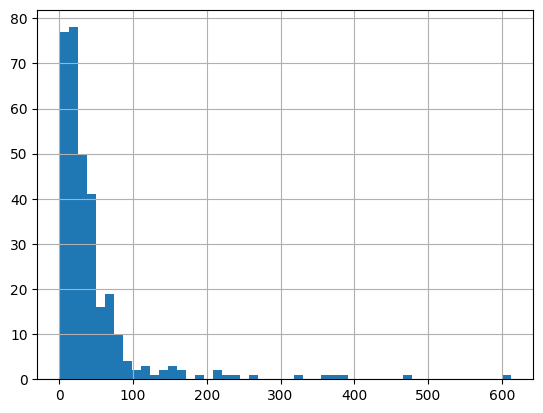

In [20]:
df_test.n_points.hist(bins=50)

In [21]:
df_test["n_points"].describe()

count    320.000000
mean      45.118750
std       66.739927
min        1.000000
25%       14.000000
50%       26.500000
75%       48.000000
max      612.000000
Name: n_points, dtype: float64

テストデータのn_pointsの分布を確認したところ、30ステップまでが多いことがわかったことから、学習データにおいても30ステップまでの距離、時間、平均速度を特徴量として追加することとする。

## Training base model
欠損値の保管は一旦無視。特徴量として除外するのは、ID関連、ORIGIN_CALL, ORIGIN_STAND。

In [22]:
features = [
    "start_lat",
    "start_lon",
    "partial_distance",
    "run_time_hr",
    "avg_speed_kmh",
    "n_points",
]
x_reduced = df_sample[features]
y_lat = df_sample["end_lat"]
y_lon = df_sample["end_lon"]

In [23]:
x_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51144 entries, 0 to 51319
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_lat         51144 non-null  float64
 1   start_lon         51144 non-null  float64
 2   partial_distance  51144 non-null  float64
 3   run_time_hr       51144 non-null  float64
 4   avg_speed_kmh     51144 non-null  float64
 5   n_points          51144 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 2.7 MB


In [24]:
def training_model(x,y, model_type="linear", use_cv=True, n_splits=5):
    """ train regression model(linear regression or random forest"""
    steps=[]
    steps.append(('scaler', StandardScaler()))
    
    # model selection
    if model_type == "linear":
        steps.append(('regressor', LinearRegression()))
    elif model_type == "random_forest":
        steps.append(('regressor', RandomForestRegressor()))
    
    pipe = Pipeline(steps)

    # cross-validation
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipe, x, y, cv=kf, scoring='neg_mean_squared_error')
        print(f"CV Mean Squared Error: {-np.mean(cv_scores)}")
        pipe.fit(x, y)
    else:
        pipe.fit(x, y)
        print("Model trained without cross-validation.")
    
    return pipe

def evaluate_model(x, y_lat, y_lon, test_size=0.2, model_type="linear", use_cv=False):
    """ evaluate latitude / longitude prediction model using Haversine distance """
    x_train, x_test, y_train_lat, y_test_lat = train_test_split(x, y_lat, test_size=test_size, random_state=42)
    _, _, y_train_lon, y_test_lon = train_test_split(x, y_lon, test_size=test_size, random_state=42)
    
    # training model
    model_lat = training_model(x_train, y_train_lat, model_type=model_type, use_cv=use_cv)
    model_lon = training_model(x_train, y_train_lon, model_type=model_type, use_cv=use_cv)
    
    # prediction
    pred_lat = model_lat.predict(x_test)
    pred_lon = model_lon.predict(x_test)

    # calculate Haversine distance error
    error_km = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
    
    print(f"error kilo of mean: {error_km.mean():.3f} km")
    print(f"error kilo of median: {np.median(error_km):.3f} km")
    
    return model_lat, model_lon, error_km


In [25]:
# evaluate model
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="random_forest")

Model trained without cross-validation.
Model trained without cross-validation.
error kilo of mean: 2.706 km
error kilo of median: 1.873 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 17194    1.781976
 48947    0.313870
 48741    0.975662
 14134    7.459273
 12432    2.352060
            ...   
 50807    2.584789
 21093    0.493985
 37469    7.258618
 32902    1.952480
 2307     3.460973
 Length: 10229, dtype: float64)

In [26]:
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="linear")

Model trained without cross-validation.
Model trained without cross-validation.
error kilo of mean: 3.005 km
error kilo of median: 2.295 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 17194     1.396649
 48947     0.967738
 48741     1.828312
 14134     8.158131
 12432     2.170682
            ...    
 50807     3.631078
 21093     0.153832
 37469    10.244421
 32902     0.695041
 2307      4.784169
 Length: 10229, dtype: float64)

In [27]:
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="random_forest", use_cv=True)

CV Mean Squared Error: 0.0014668001432835058
CV Mean Squared Error: 0.0011351908976790755
error kilo of mean: 2.715 km
error kilo of median: 1.885 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 17194    1.466064
 48947    0.461006
 48741    0.931446
 14134    7.436089
 12432    2.387677
            ...   
 50807    2.590452
 21093    0.501805
 37469    7.120702
 32902    2.012150
 2307     3.463088
 Length: 10229, dtype: float64)

In [28]:
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="linear", use_cv=True)

CV Mean Squared Error: 0.0013704452551151815
CV Mean Squared Error: 0.001262299662106506
error kilo of mean: 3.005 km
error kilo of median: 2.295 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 17194     1.396649
 48947     0.967738
 48741     1.828312
 14134     8.158131
 12432     2.170682
            ...    
 50807     3.631078
 21093     0.153832
 37469    10.244421
 32902     0.695041
 2307      4.784169
 Length: 10229, dtype: float64)

## test data validation with base model

In [29]:
def preprocess_taxi(df, partial_cut=30):
    """ Preprocess taxi trajectory data to generate features from POLYLINE"""
    
    # POLYLINE to list
    df["polyline_list"] = df["POLYLINE"].apply(ast.literal_eval)
    df["n_points"] = df["polyline_list"].apply(len)
    
    # start points
    df["start_lon"] = df["polyline_list"].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)
    df["start_lat"] = df["polyline_list"].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)
    
    # end points (only if not exists)
    if "end_lon" not in df.columns:
        df["end_lon"] = df["polyline_list"].apply(lambda x: x[-1][0] if len(x) > 0 else np.nan)
        df["end_lat"] = df["polyline_list"].apply(lambda x: x[-1][1] if len(x) > 0 else np.nan)
    
    # partial polyline
    df["partial_polyline"] = df["polyline_list"].apply(
        lambda x: x[:partial_cut] if len(x) > partial_cut else x
    )
    
    # calculate distance, run time, avg speed
    df["partial_distance"] = df["partial_polyline"].apply(calculate_distance)
    df["run_time_sec"] = df["n_points"] * 15
    df["run_time_hr"] = df["run_time_sec"] / 3600
    df["avg_speed_kmh"] = df["partial_distance"] / df["run_time_hr"].replace(0, np.nan)
    
    # drop rows with missing start coordinates
    df = df.dropna(subset=["start_lon", "start_lat"])
    
    return df

In [30]:
df_test = preprocess_taxi(df_test, partial_cut=30)
x_test_reduced = df_test[features]


In [31]:
model_lat, model_lon, error_km = evaluate_model(
    x_reduced, y_lat, y_lon, 
    test_size=0.2, model_type="random_forest"
)

# predict on test data
pred_lat = model_lat.predict(x_test_reduced)
pred_lon = model_lon.predict(x_test_reduced)

Model trained without cross-validation.
Model trained without cross-validation.
error kilo of mean: 2.710 km
error kilo of median: 1.875 km


In [32]:
df_submit = pd.DataFrame({
    "TRIP_ID": df_test["TRIP_ID"],
    "LATITUDE": pred_lat,
    "LONGITUDE": pred_lon
})

df_submit.to_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/taxi_trajectory_submission.csv", index=False)

test dataによるsubmissionの結果は以下の通り。
- model : RandomForestRegressor(n_estimators=100, random_state=42)
- public score: 3.84330 km
- private score: 4.03655 km

## feature importance

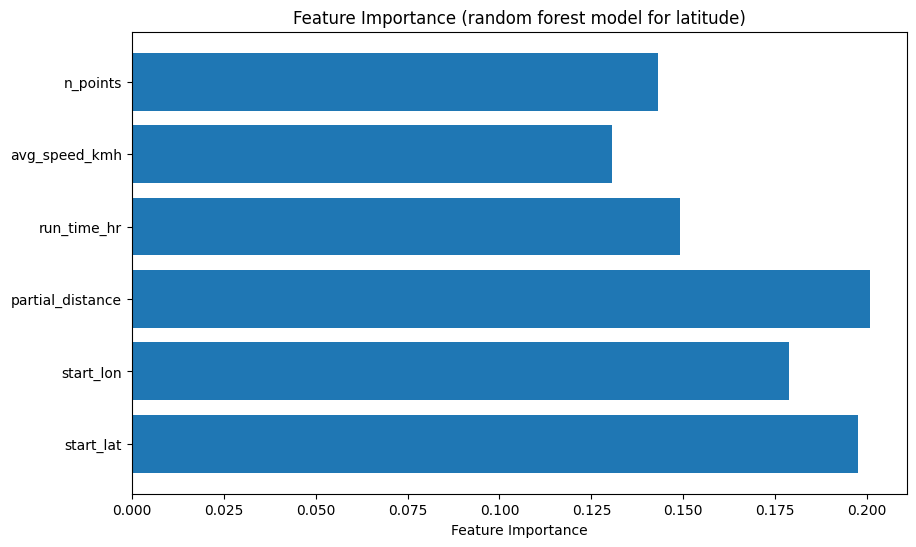

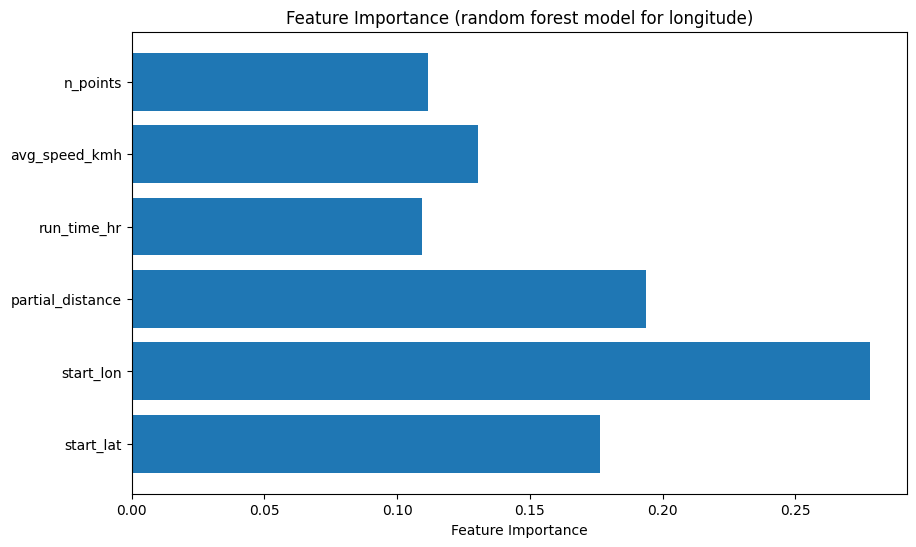

In [35]:
# model feature importance visualization
model_lat_rf = model_lat.named_steps['regressor']
model_lon_rf = model_lon.named_steps['regressor']

# latitude feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(model_lat_rf.feature_importances_)), model_lat_rf.feature_importances_)
plt.yticks(range(len(model_lat_rf.feature_importances_)), x_reduced.columns)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (random forest model for latitude)")
plt.show()

# longitude feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(model_lon_rf.feature_importances_)), model_lon_rf.feature_importances_)
plt.yticks(range(len(model_lon_rf.feature_importances_)), x_reduced.columns)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (random forest model for longitude)")
plt.show()

start_lon, start_lat, partial_distanceが重要な特徴量であることがわかった。

## feature engineering ver2
- CALL_TYPE, DAYTYPEのエンコーディング
- TIMESTAMPから時間に関する特徴量の生成

In [36]:
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,n_points,start_lon,start_lat,end_lon,end_lat,partial_polyline,partial_distance,run_time_sec,run_time_hr,avg_speed_kmh
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[...","[[-8.607096, 41.150286], [-8.607123, 41.150214...",71,-8.607096,41.150286,-8.679096,41.158161,"[[-8.607096, 41.150286], [-8.607123, 41.150214...",2.643182,1065,0.295833,8.934698
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8...","[[-8.638533, 41.159133], [-8.63856, 41.15907],...",70,-8.638533,41.159133,-8.585847,41.148756,"[[-8.638533, 41.159133], [-8.63856, 41.15907],...",1.116930,1050,0.291667,3.829474
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-...","[[-8.60652, 41.144562], [-8.606934, 41.144724]...",38,-8.606520,41.144562,-8.594757,41.158836,"[[-8.60652, 41.144562], [-8.606934, 41.144724]...",2.290315,570,0.158333,14.465149
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[...","[[-8.628246, 41.157333], [-8.627733, 41.157657...",31,-8.628246,41.157333,-8.605197,41.146668,"[[-8.628246, 41.157333], [-8.627733, 41.157657...",3.021838,465,0.129167,23.394877
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[...","[[-8.607123, 41.150331], [-8.607114, 41.150295...",231,-8.607123,41.150331,-8.610255,41.153445,"[[-8.607123, 41.150331], [-8.607114, 41.150295...",3.971895,3465,0.962500,4.126644


In [37]:
df_sample["CALL_TYPE"].value_counts()

CALL_TYPE
B    24284
C    15884
A    10976
Name: count, dtype: int64

In [ ]:
df_sample["DAY_TYPE"].value_counts()

DAY_TYPE
A    51144
Name: count, dtype: int64

In [40]:
df_sample["MISSING_DATA"].value_counts()

MISSING_DATA
False    51143
True         1
Name: count, dtype: int64

In [41]:
# generate time-related features from TIMESTAMP
df_sample["datetime"] = pd.to_datetime(df_sample["TIMESTAMP"], unit='s')
df_sample["hour"] = df_sample["datetime"].dt.hour
df_sample["weekday"] = df_sample["datetime"].dt.weekday
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,...,end_lon,end_lat,partial_polyline,partial_distance,run_time_sec,run_time_hr,avg_speed_kmh,datetime,hour,weekday
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[...","[[-8.607096, 41.150286], [-8.607123, 41.150214...",...,-8.679096,41.158161,"[[-8.607096, 41.150286], [-8.607123, 41.150214...",2.643182,1065,0.295833,8.934698,2014-05-04 07:54:51,7,6
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8...","[[-8.638533, 41.159133], [-8.63856, 41.15907],...",...,-8.585847,41.148756,"[[-8.638533, 41.159133], [-8.63856, 41.15907],...",1.116930,1050,0.291667,3.829474,2014-05-01 07:12:31,7,3
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-...","[[-8.60652, 41.144562], [-8.606934, 41.144724]...",...,-8.594757,41.158836,"[[-8.60652, 41.144562], [-8.606934, 41.144724]...",2.290315,570,0.158333,14.465149,2013-10-29 14:27:31,14,1
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[...","[[-8.628246, 41.157333], [-8.627733, 41.157657...",...,-8.605197,41.146668,"[[-8.628246, 41.157333], [-8.627733, 41.157657...",3.021838,465,0.129167,23.394877,2014-05-10 21:48:25,21,5
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[...","[[-8.607123, 41.150331], [-8.607114, 41.150295...",...,-8.610255,41.153445,"[[-8.607123, 41.150331], [-8.607114, 41.150295...",3.971895,3465,0.962500,4.126644,2014-01-28 14:46:55,14,1


In [44]:
agg_df = (
    df_sample.groupby(["weekday", "hour"])["partial_distance"]
    .mean().reset_index()
    .rename(columns={"partial_distance": "avg_partial_distance_by_time"})
)
agg_df.head()

,weekday,hour,avg_partial_distance_by_time
0,0,0,3.566948
1,0,1,3.195287
2,0,2,4.070658
3,0,3,4.636766
4,0,4,4.746107


In [45]:
df_sample = df_sample.merge(agg_df, on=["weekday", "hour"], how="left")
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,...,end_lat,partial_polyline,partial_distance,run_time_sec,run_time_hr,avg_speed_kmh,datetime,hour,weekday,avg_partial_distance_by_time
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[...","[[-8.607096, 41.150286], [-8.607123, 41.150214...",...,41.158161,"[[-8.607096, 41.150286], [-8.607123, 41.150214...",2.643182,1065,0.295833,8.934698,2014-05-04 07:54:51,7,6,3.624797
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8...","[[-8.638533, 41.159133], [-8.63856, 41.15907],...",...,41.148756,"[[-8.638533, 41.159133], [-8.63856, 41.15907],...",1.116930,1050,0.291667,3.829474,2014-05-01 07:12:31,7,3,3.011890
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-...","[[-8.60652, 41.144562], [-8.606934, 41.144724]...",...,41.158836,"[[-8.60652, 41.144562], [-8.606934, 41.144724]...",2.290315,570,0.158333,14.465149,2013-10-29 14:27:31,14,1,2.583428
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[...","[[-8.628246, 41.157333], [-8.627733, 41.157657...",...,41.146668,"[[-8.628246, 41.157333], [-8.627733, 41.157657...",3.021838,465,0.129167,23.394877,2014-05-10 21:48:25,21,5,3.003244
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[...","[[-8.607123, 41.150331], [-8.607114, 41.150295...",...,41.153445,"[[-8.607123, 41.150331], [-8.607114, 41.150295...",3.971895,3465,0.962500,4.126644,2014-01-28 14:46:55,14,1,2.583428


特徴量エンジニアリングに関する考察:
- DAY_TYPEのvalue_countsを見ると、Aしか存在していないことがわかったため、特徴量としては使用しない。
- CALL_TYPEのvalue_countsを見ると、Bが多いため、one-hot encodingでエンコーディングする。
- MISSING_DATAのvalue_countsを見ると、Trueが一つだけ存在しているが、精度には関係しないことを踏まえて、無視する。
    - 線形モデルはdrop_first=Trueでエンコーディング
    - 決定木モデルはそのまま使用
- TIMESTAMPから時間に関する特徴量を生成する。
    - 時間帯(hour)と曜日(weekday),時間帯×曜日の組み合わせでpartial_distanceの平均値を集計し、特徴量として追加する。

## train model with feature engineering ver2
Add features:
- CALL_TYPE (one-hot encoding)
- hour (from TIMESTAMP)
- weekday (from TIMESTAMP)
- avg_partial_distance_by_time (aggregated feature by hour and weekday)

In [52]:
features_ver2 = [
    "start_lat",
    "start_lon",
    "partial_distance",
    "avg_partial_distance_by_time", # 時間帯・曜日の平均距離
    "hour",
    "weekday",
    "run_time_hr",
    "avg_speed_kmh",
    "n_points",
    "CALL_TYPE",  # add CALL_TYPE as categorical feature
]

In [53]:
x_reduced_ver2 = df_sample[features_ver2]
y_lat = df_sample["end_lat"]
y_lon = df_sample["end_lon"]

x_reduced_ver2.head()

,start_lat,start_lon,partial_distance,avg_partial_distance_by_time,hour,weekday,run_time_hr,avg_speed_kmh,n_points,CALL_TYPE
0,41.150286,-8.607096,2.643182,3.624797,7,6,0.295833,8.934698,71,B
1,41.159133,-8.638533,1.116930,3.011890,7,3,0.291667,3.829474,70,C
2,41.144562,-8.606520,2.290315,2.583428,14,1,0.158333,14.465149,38,B
3,41.157333,-8.628246,3.021838,3.003244,21,5,0.129167,23.394877,31,B
4,41.150331,-8.607123,3.971895,2.583428,14,1,0.962500,4.126644,231,B


In [59]:
x_reduced_ver2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51144 entries, 0 to 51143
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   start_lat                     51144 non-null  float64
 1   start_lon                     51144 non-null  float64
 2   partial_distance              51144 non-null  float64
 3   avg_partial_distance_by_time  51144 non-null  float64
 4   hour                          51144 non-null  int32  
 5   weekday                       51144 non-null  int32  
 6   run_time_hr                   51144 non-null  float64
 7   avg_speed_kmh                 51144 non-null  float64
 8   n_points                      51144 non-null  int64  
 9   CALL_TYPE                     51144 non-null  object 
dtypes: float64(6), int32(2), int64(1), object(1)
memory usage: 3.5+ MB


In [73]:
def training_model_timestamp_calltype(x, y, model_type="linear", use_cv=True, n_splits=5):
    """ train regression model(linear regression, random forest, XGBoost, LightGBM)
        encoding call_type & timestamp features """

    x = x.copy()

    # dtypes conversion
    for col in ["hour", "weekday"]:
        if col in x.columns:
            x[col] = x[col].astype(float)

    # encoding CALL_TYPE
    encoding_cols = ["CALL_TYPE"]
    x = pd.get_dummies(x, columns=encoding_cols, drop_first=False)
    steps = []

    # scaling for linear model
    if model_type == "linear":
        steps.append(('scaler', StandardScaler()))

    # model selection
    if model_type == "linear":
        steps.append(('regressor', LinearRegression()))
    elif model_type == "random_forest":
        steps.append(('regressor', RandomForestRegressor(random_state=42, n_jobs=-1)))
    elif model_type == "xgboost":
        steps.append(('regressor', XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.05, n_jobs=-1)))
    elif model_type == "lightgbm":
        steps.append(('regressor', LGBMRegressor(random_state=42, n_estimators=300, learning_rate=0.05, num_leaves=31)))

    pipe = Pipeline(steps)

    # cross-validation
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipe, x, y, cv=kf, scoring='neg_mean_squared_error')
        print(f"CV Mean Squared Error: {-np.mean(cv_scores):.6f}")
    
    # always fit full data for final model
    pipe.fit(x,y)

    # feature names
    pipe.feature_names_ = x.columns.tolist()
    return pipe


def evaluate_model_cv(x, y_lat, y_lon, test_size=0.2, model_type="linear", use_cv=False, n_splits=5):
    """ evaluate latitude / longitude prediction model using Haversine distance """
# Cross-validationモード
    if use_cv:
        print(f"\n===== Cross-Validation ({n_splits}-Fold) mode =====")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_errors = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train_lat, y_test_lat = y_lat.iloc[train_idx], y_lat.iloc[test_idx]
            y_train_lon, y_test_lon = y_lon.iloc[train_idx], y_lon.iloc[test_idx]

            # モデル学習
            model_lat = training_model_timestamp_calltype(x_train, y_train_lat, model_type=model_type, use_cv=False)
            model_lon = training_model_timestamp_calltype(x_train, y_train_lon, model_type=model_type, use_cv=False)

            # カラム揃え
            x_test = x_test.copy()

            for model in [model_lat, model_lon]:
                for col in model.feature_names_:
                    if col not in x_test.columns:
                        x_test.loc[:, col] = 0
                x_test = x_test[model.feature_names_]

            # 予測
            pred_lat = model_lat.predict(x_test)
            pred_lon = model_lon.predict(x_test)

            # Haversine距離
            fold_error = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
            print(f"Fold mean error: {fold_error.mean():.3f} km | median: {np.median(fold_error):.3f} km")
            fold_errors.append(fold_error.mean())

        print("\n===== Cross-Validation Summary =====")
        print(f"Mean error across folds: {np.mean(fold_errors):.3f} km ± {np.std(fold_errors):.3f}")
        return None, None, np.array(fold_errors)

    # 通常モード（ホールドアウト）
    else:
        x_train, x_test, y_train_lat, y_test_lat = train_test_split(x, y_lat, test_size=test_size, random_state=42)
        _, _, y_train_lon, y_test_lon = train_test_split(x, y_lon, test_size=test_size, random_state=42)
        
        # fit model
        model_lat = training_model_timestamp_calltype(x_train, y_train_lat, model_type=model_type, use_cv=False)
        model_lon = training_model_timestamp_calltype(x_train, y_train_lon, model_type=model_type, use_cv=False)
        
        # column alignment for test set
        x_test = x_test.copy()

        for model in [model_lat, model_lon]:
            for col in model.feature_names_:
                if col not in x_test.columns:
                    x_test.loc[:, col] = 0
            x_test = x_test[model.feature_names_]

        # prediction
        pred_lat = model_lat.predict(x_test)
        pred_lon = model_lon.predict(x_test)

        # evaluation using Haversine distance
        error_km = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
        print(f"error kilo of mean: {error_km.mean():.3f} km")
        print(f"error kilo of median: {np.median(error_km):.3f} km")
        
        return model_lat, model_lon, error_km

    

In [74]:
# model_type and use_cv combinations
model_types = ["linear", "random_forest", "xgboost", "lightgbm"]
use_cv_options = [False, True]

results = []  # results storage

for model_type in model_types:
    for use_cv in use_cv_options:
        print("=" * 60)
        print(f"Model: {model_type} | use_cv: {use_cv}")
        print("-" * 60)

        # evaluate model
        model_lat, model_lon, error_km = evaluate_model_cv(
            x_reduced_ver2, y_lat, y_lon,
            test_size=0.2,
            model_type=model_type,
            use_cv=use_cv
        )

        # store results
        result = {
            "model_type": model_type,
            "use_cv": use_cv,
            "mean_error_km": error_km.mean(),
            "median_error_km": np.median(error_km)
        }
        results.append(result)

# display results
df_results = pd.DataFrame(results)
print("\n=== モデル比較結果 ===")
print(df_results)


Model: linear | use_cv: False
------------------------------------------------------------
error kilo of mean: 3.004 km
error kilo of median: 2.295 km
Model: linear | use_cv: True
------------------------------------------------------------

===== Cross-Validation (5-Fold) mode =====

--- Fold 1/5 ---
Fold mean error: 3.004 km | median: 2.295 km

--- Fold 2/5 ---
Fold mean error: 2.964 km | median: 2.256 km

--- Fold 3/5 ---
Fold mean error: 3.066 km | median: 2.292 km

--- Fold 4/5 ---
Fold mean error: 2.993 km | median: 2.298 km

--- Fold 5/5 ---
Fold mean error: 3.013 km | median: 2.284 km

===== Cross-Validation Summary =====
Mean error across folds: 3.008 km ± 0.033
Model: random_forest | use_cv: False
------------------------------------------------------------
error kilo of mean: 2.647 km
error kilo of median: 1.839 km
Model: random_forest | use_cv: True
------------------------------------------------------------

===== Cross-Validation (5-Fold) mode =====

--- Fold 1/5 ---
Fol